# `mle-hyperopt`: Lightweight Hyperparameter Optimization
### Author: [@RobertTLange](https://twitter.com/RobertTLange) [Last Update: October 2021][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/mle-logging/blob/main/examples/getting_started.ipynb)

Validating a simulation across a large range of parameters or tuning the hyperparameters of a neural network is common practice for every computational scientist. There are a plethora of open source tools that implement individual algorithms, but many of them are either combersome to set up and log or follow diverse syntax, which makes it hard to easily wrap them. For my personal research setup I wanted a simple API that allows me to generate batches of parameter configurations for various types of experiments and that comes with a set of handy features. These included the following: 

- **API simplicity**: The `mle-hyperopt` uses a simple interface alá `strategy.ask()` and `strategy.tell()`. Furthermore, many of the search spaces can be exported and repurposed. E.g. if you want to autovectorize/`jax.vmap` over a grid of parameters.
- **Strategy diversity**: While most hyperparameter tools implement the newest population-based search algorithms and Bayesian Optimization variants, often times they do not feature simple grid search. Even though [Bergstra and Bengio (2012)](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) showed that random search can be more efficient, often an intuitive understanding of a grey-box model can be enhanced by semi-exhaustive evaluation.
- **Interactive search space refinement**: After a certain set of search iterations, it can make sense to refine your search space boundaries based on the top performing configurations. This way the search can focus on a smaller range of promising configurations. This was for example done in [Schmidt et al. (2021)](https://arxiv.org/abs/2007.01547) and significantly improve computation efficient resource allocation. 
- **Exporting of configuration files**: Often times I want to submit a batch of training runs to a compute cluster (Slurm, etc.) and need to execute a downstream training routine that looks somewhat as follows: `python train.py --config_fname config.yaml`. In that case it is useful to have one script that executes calls to the cluster scheduler after having generated the configurations.
- **Storage and reloading of previous search logs**: I was astonished by how few libraries provide the simple utility of exporting and importing a previous search experiment for later continuation. E.g., in order to accomplish something similar in the FAIR's awesome [nevergrad](https://facebookresearch.github.io/nevergrad/) library, one has to write manual functionality that dumps the search log, reloads and supplies the previously stored results to a new search strategy instance.

And this was how the `mle-hyperopt` package was born. [***Note***: I by no means claim that this is something novel. Most likely you may your own substitute tool. But maybe you find a couple of the package's features useful. So hang in there 🤗] As of writing the package includes a set of diverse (e.g. single vs. multi-objective, model-free vs. model-based) search algorithms:

| | Search Type           | Description | `search_config` |
|----|----------------------- | ----------- | --------------- |
|<img src="https://github.com/RobertTLange/mle-hyperopt/blob/main/docs/grid.png?raw=true" alt="drawing" width="50"/>|  `GridSearch`          |  Search over list of discrete values  | - |
|<img src="https://github.com/RobertTLange/mle-hyperopt/blob/main/docs/random.png?raw=true" alt="drawing" width="50"/>|  `RandomSearch`        |  Random search over variable ranges         | `refine_after`, `refine_top_k` |
|<img src="https://github.com/RobertTLange/mle-hyperopt/blob/main/docs/coordinate.png?raw=true" alt="drawing" width="50"/>|  `CoordinateSearch`    |  Coordinate-wise optim. with defaults | `order`, `defaults`
|<img src="https://github.com/RobertTLange/mle-hyperopt/blob/main/docs/smbo.png?raw=true" alt="drawing" width="50"/>|  `SMBOSearch`          |  Sequential model-based optim.        | `base_estimator`, `acq_function`, `n_initial_points`
|<img src="https://github.com/RobertTLange/mle-hyperopt/blob/main/docs/nevergrad.png?raw=true" alt="drawing" width="50"/>|  `NevergradSearch`     |  Multi-objective [nevergrad](https://facebookresearch.github.io/nevergrad/) wrapper | `optimizer`, `budget_size`, `num_workers`

Each strategy implements a separate search space which one can sample from. The API follows the standard `ask`, `eval`, `tell` paradigm. The general package structure is summarized as follows:

<img src="https://github.com/RobertTLange/mle-hyperopt/blob/main/docs/mle_hyperopt_structure.png?raw=true" alt="drawing" width="900"/>

In the remainder of this 'blog notebook' we will walk through the different features and use-cases. Let's start by implementing a small 'synthetic' helper function that evaluates the performance of a combination of 3 standard hyperparameters -- learning rate, batchsize and architecture:

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

try:
    import mle_hyperopt
except:
    !pip install -q mle-hyperopt
    import mle_hyperopt

def fake_train(lrate, batch_size, arch):
    """Optimum: lrate=0.2, batch_size=4, arch='conv'."""
    f1 = ((lrate - 0.2) ** 2 + ((batch_size - 4)/4) ** 2
          + (0 if arch == "conv" else 0.2))
    return f1

## Basic API Usage: Grid Search <img src="https://github.com/RobertTLange/mle-hyperopt/blob/main/docs/grid.png?raw=true" alt="drawing" width="50"/>

Imagine you simply want to loop over a discretized range of hyperparameters for our training surrogate. In order to do so we first need to define the search space. The `mle-hyperopt` package supports real-, integer- and categorically-valued parameters, whose ranges you specify via dictionaries. For real variables and integers you have to specifiy the beginning and end of the range (`begin`/`end`) as well as a prior (e.g. uniform or log-uniform) or the number of bins to discretize (`prior`/`bins`). For categorical variables simply supply a list of values:

| | Variable            | Type | Space Specification |
| --- |----------------------- | ----------- | --------------- |
|<img src="https://github.com/RobertTLange/mle-hyperopt/blob/main/docs/real.png?raw=true" alt="drawing" width="50"/> |  **`real`**          |  Real-valued  | `Dict`: `begin`, `end`, `prior`/`bins` (grid) |
|<img src="https://github.com/RobertTLange/mle-hyperopt/blob/main/docs/integer.png?raw=true" alt="drawing" width="50"/>  |  **`integer`**        |  Integer-valued         | `Dict`: `begin`, `end`, `prior`/`bins` (grid) |
|<img src="https://github.com/RobertTLange/mle-hyperopt/blob/main/docs/categorical.png?raw=true" alt="drawing" width="50"/> |  **`categorical`**  |  Categorical        | `List`: Values to search over

Let's now instantiate of search strategy for a range of learning rates and batch sizes as well as two network types we want to evaluate:

In [2]:
from mle_hyperopt import GridSearch
# Instantiate grid search class
strategy = GridSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "bins": 5}},
                      integer={"batch_size": {"begin": 1,
                                              "end": 5,
                                              "bins": 1}},
                      categorical={"arch": ["mlp", "cnn"]},
                      verbose=True)

If you set the verbosity option, the logged data will be printed to your console using the beautiful [rich](https://github.com/willmcgugan/rich) package. We are now ready to ask our search strategy for a set of proposal candidates:

In [3]:
# Ask the strategy for five configs to evaluate
configs = strategy.ask(batch_size=5)
configs

[{'arch': 'mlp', 'batch_size': 1, 'lrate': 0.1},
 {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2},
 {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.30000000000000004},
 {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.4},
 {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.5}]

Next, we can quickly evaluate our fake surrogate objective for the two proposal configurations and afterwards update the strategy with the collected data (e.g. a validation score). Note that the API assumes that we are minimizing an objective. If you want to instead maximize simply provide the option `maximize_objective = True` when instantiating the search strategy.

In [4]:
# Simple ask - eval - tell API
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

The log can be stored and reloaded using `strategy.save()` and `strategy.load()`:

In [5]:
# Storing of results to .pkl
strategy.save("search_log.json")

# Reloading of results from .pkl
strategy.load("search_log.json")

Note that no configuration is added to the log since they were already previously archived. This is different if we instatiate a new strategy with the `reload_path` option. In this case the new search strategy will load the previously stored log from the json file:

In [6]:
strategy = GridSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "bins": 5}},
                      integer={"batch_size": {"begin": 1,
                                              "end": 5,
                                              "bins": 1}},
                      categorical={"arch": ["mlp", "cnn"]},
                      reload_path="search_log.json")

There are different ways how you can access and analyse the search results:

- `strategy.log` will return the raw internal list of evaluation results.
- `strategy.to_df()` will return the flattened log as a pandas dataframe.
- `strategy.get_best(top_k)` will retrieve the `top_k` best performing configurations.

But my two favorite tools are a plot of the best performance over search iterations and the overall ranking:

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Best Objective Value'}, xlabel='# Config Evaluations', ylabel='Objective'>)

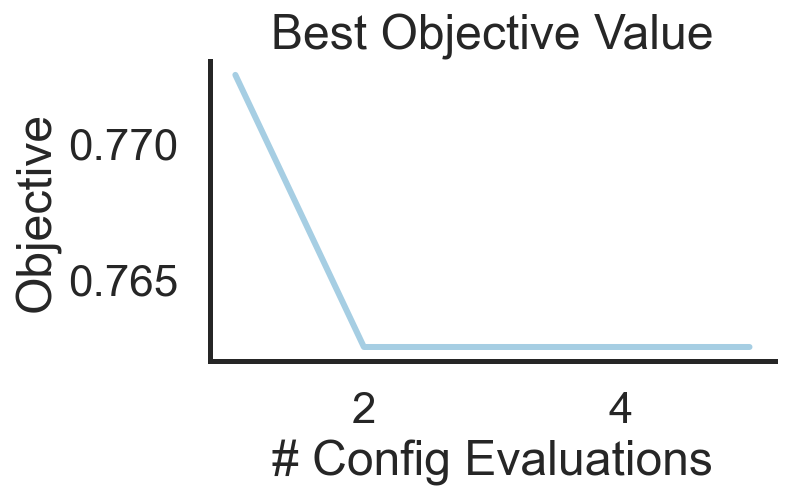

In [7]:
# Plot timeseries of best performing score over search iterations
strategy.plot_best()

In [8]:
# Print out ranking of best performers
strategy.print_ranking(top_k=4)

In case you don't want to search over all configuration parameters, you can also add a dictionary of fixed parameters at instantiation (`fixed_params`). Additionally, you can also directly store the configurations as files by setting `store=True` (or also provide the filenames as a list using the `config_fnames` option). Below is an example for the case where we want to add a `momentum` parameter with value 0.9 to all configurations:

In [9]:
strategy = GridSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "bins": 5}},
                      integer={"batch_size": {"begin": 1,
                                              "end": 5,
                                              "bins": 1}},
                      categorical={"arch": ["mlp", "cnn"]},
                      fixed_params={"momentum": 0.9})

strategy.ask(2, store=True)

([{'arch': 'mlp', 'batch_size': 1, 'lrate': 0.1, 'momentum': 0.9},
  {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2, 'momentum': 0.9}],
 ['eval_0.yaml', 'eval_1.yaml'])

## Random Search & Search Space Refinement <img src="https://github.com/RobertTLange/mle-hyperopt/blob/main/docs/random.png?raw=true" alt="drawing" width="50"/>

Next let's see how we can define a random search strategy with priors over variables. As before we will define our search space using a set of dictionaries, but now the real and integer parameters will have a uniform or log-uniform prior placed over their range:

In [10]:
from mle_hyperopt import RandomSearch

strategy = RandomSearch(real={"lrate": {"begin": 0.1,
                                        "end": 0.5,
                                        "prior": "uniform"}},
                        integer={"batch_size": {"begin": 1,
                                                "end": 5,
                                                "prior": "log-uniform"}},
                        categorical={"arch": ["mlp", "cnn"]},
                        search_config={"refine_after": 5,
                                       "refine_top_k": 2},
                        seed_id=42,
                        verbose=True)

configs = strategy.ask(5)
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

In the random search instantiation above we have additionally set the random seed for reproducibility and supplied a `search_config` dictionary with two keys: `refine_after` and `refine_top_k`. These two define when and how the search space will be contracted. More specifically, the ranges and categorical values will be altered to only include those of the top-k best performing configurations stored in the strategy log. This allows the strategy to spend more time sampling from regions of the search space, which have proven well-performing.

## SMBO <img src="https://github.com/RobertTLange/mle-hyperopt/blob/main/docs/smbo.png?raw=true" alt="drawing" width="50"/> & Coordinate-Wise Search <img src="https://github.com/RobertTLange/mle-hyperopt/blob/main/docs/coordinate.png?raw=true" alt="drawing" width="50"/>

The `mle-hyperopt` package also wraps around the [`scikit-optimize`](https://scikit-optimize.github.io/stable/index.html) API and provides a simple interface for SMBO ([Hutter et al., 2011](https://ml.informatik.uni-freiburg.de/wp-content/uploads/papers/11-LION5-SMAC.pdf)). You can customize the optimizer object with the `search_config` options. This includes different surrogate models ("GP", "RF", "ET", "GBRT") and acquisition functions ("LCB", "EI", "PI") as well as random initial seeding configurations. For more information check out the scikit optimizer [documentation](https://scikit-optimize.github.io/stable/modules/generated/skopt.Optimizer.html#skopt.Optimizer).

In [11]:
from mle_hyperopt import SMBOSearch

strategy = SMBOSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "prior": "uniform"}},
                      integer={"batch_size": {"begin": 1,
                                              "end": 5,
                                              "prior": "uniform"}},
                      search_config={"base_estimator": "GP",
                                     "acq_function": "gp_hedge",
                                     "n_initial_points": 5},
                      fixed_params={"arch": "cnn"})

configs = strategy.ask(5)
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

Furthermore, I also implemented a more heuristic search, which I often would implement manually: We start by scanning one parameter and hold the other considered parameters fixed to a pre-specified `defaults` value. Afterwards, the previously scanned parameter is in turn fixed to its best value and we go over to the next parameter. We repeat this coordinate-wise search until all specified parameters are completed. The order in which we search over the variables is specified in the `search_config`.

In [12]:
from mle_hyperopt import CoordinateSearch

strategy = CoordinateSearch(real={"lrate": {"begin": 0.1,
                                            "end": 0.5,
                                            "bins": 5}},
                            integer={"batch_size": {"begin": 1,
                                                    "end": 5,
                                                    "bins": 5}},
                            categorical={"arch": ["mlp", "cnn"]},
                            search_config={"order": ["lrate", "batch_size", "arch"],
                                           "defaults": {"lrate": 0.1,
                                                        "batch_size": 3,
                                                        "arch": "mlp"}},
                            verbose=True)

configs = strategy.ask(5)
configs

[{'arch': 'mlp', 'batch_size': 3, 'lrate': 0.1},
 {'arch': 'mlp', 'batch_size': 3, 'lrate': 0.2},
 {'arch': 'mlp', 'batch_size': 3, 'lrate': 0.30000000000000004},
 {'arch': 'mlp', 'batch_size': 3, 'lrate': 0.4},
 {'arch': 'mlp', 'batch_size': 3, 'lrate': 0.5}]

In [13]:
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

In [14]:
configs = strategy.ask(4)
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

In [15]:
configs = strategy.ask()
values = fake_train(**configs)
strategy.tell(configs, values)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Best Objective Value'}, xlabel='# Config Evaluations', ylabel='Objective'>)

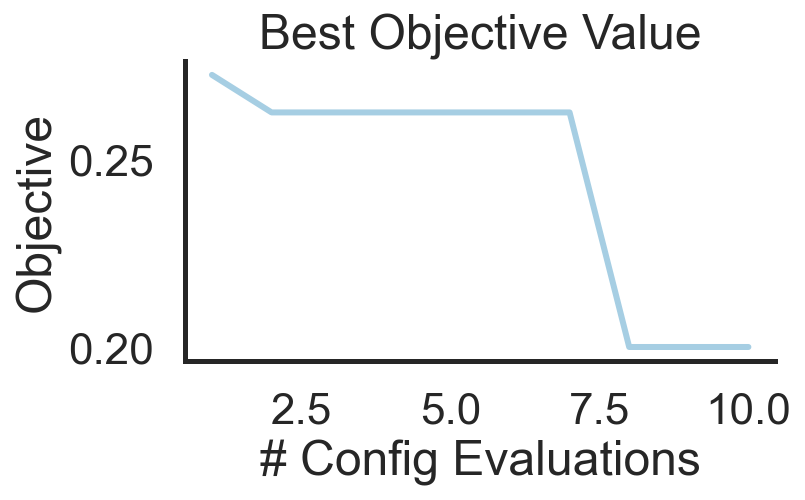

In [16]:
strategy.plot_best()

## Multi-Objective Hyperparameter Optimization with `nevergrad` <img src="https://github.com/RobertTLange/mle-hyperopt/blob/main/docs/nevergrad.png?raw=true" alt="drawing" width="50"/>

So far we have discussed a set of single objective hyperparameter search strategies. But how about cases where we are interested in more than one objective? E.g. test accuracy and inference time. For these cases and for even more diverse search strategies we wrap around the `nevergrad` library by Facebook Research. 

In [17]:
def multi_fake_train(lrate, batch_size, arch):
    # optimal for learning_rate=0.2, batch_size=4, architecture="conv"
    f1 = ((lrate - 0.2) ** 2 + (batch_size - 4) ** 2
          + (0 if arch == "conv" else 10))
    # optimal for learning_rate=0.3, batch_size=2, architecture="mlp"
    f2 = ((lrate - 0.3) ** 2 + (batch_size - 2) ** 2
          + (0 if arch == "mlp" else 5))
    return f1, f2

In [18]:
from mle_hyperopt import NevergradSearch

strategy = NevergradSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "prior": "uniform"}},
                           integer={"batch_size": {"begin": 1,
                                                   "end": 5,
                                                   "prior": "uniform"}},
                           search_config={"optimizer": "NGOpt",
                                          "budget_size": 100,
                                          "num_workers": 5},
                           fixed_params={"arch": "cnn"})

configs = strategy.ask(5)
values = [multi_fake_train(**c) for c in configs]
strategy.tell(configs, values)
strategy.log

[{'eval_id': 0,
  'params': {'lrate': 0.2895155928359631, 'batch_size': 4},
  'objective': (10.008013041360774, 9.00010992279358)},
 {'eval_id': 1,
  'params': {'lrate': 0.27813231046267645, 'batch_size': 2},
  'objective': (14.006104657938236, 5.000478195845701)},
 {'eval_id': 2,
  'params': {'lrate': 0.16412518606830023, 'batch_size': 2},
  'objective': (14.001287002274633, 5.018461965060974)},
 {'eval_id': 3,
  'params': {'lrate': 0.3172378807360612, 'batch_size': 3},
  'objective': (11.013744720679483, 6.00029714453227)},
 {'eval_id': 4,
  'params': {'lrate': 0.28916633667720637, 'batch_size': 4},
  'objective': (10.007950635596433, 9.000117368260991)}]

In [19]:
strategy.print_ranking()

# `hyperopt` decorator - minimal search wrapper

For convenience I also added a simple `hyperopt` function decorator, which allows you to automatically execute the search procedure loop. The decorator assumes that the function to evaluate directly consumes a configuration dictionary:

In [20]:
from mle_hyperopt import hyperopt

@hyperopt(strategy_type="grid",
          num_search_iters=400,
          real={"x": {"begin": -0.5, "end": 0.5, "bins": 20},
                "y": {"begin": -0.5, "end": 0.5, "bins": 20}})
def circle_objective(config):
    distance = abs((config["x"] ** 2 + config["y"] ** 2))
    return distance

strategy = circle_objective()
len(strategy)

400

Additionally you can plot the results of any grid search as follows:

(<Figure size 720x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Circles for Life\nHow beautiful can they be?'}, xlabel='x', ylabel='y'>)

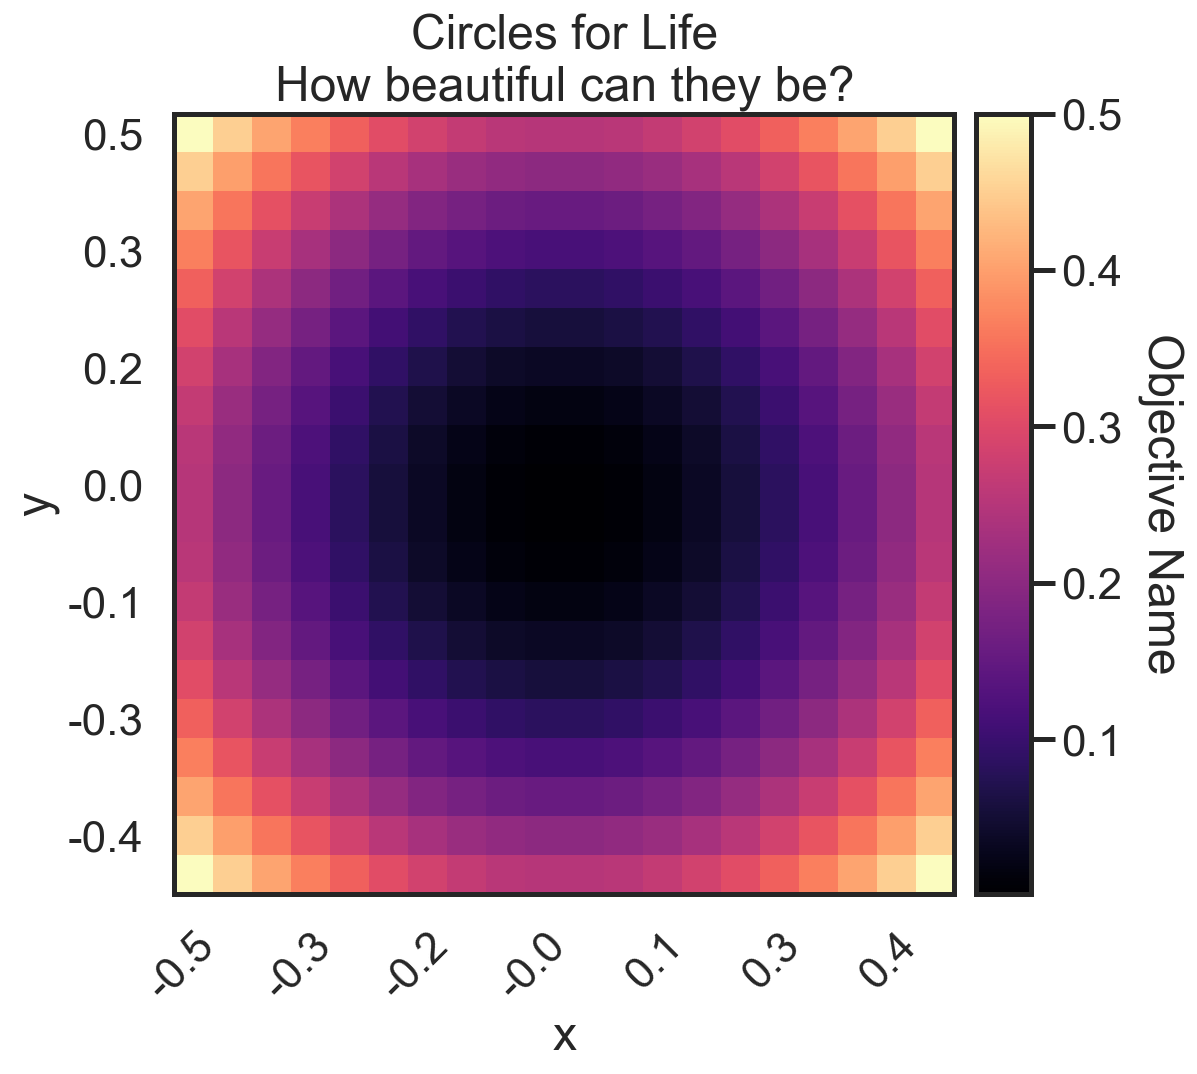

In [21]:
strategy.plot_grid(params_to_plot=["x", "y"],
                   target_to_plot="objective",
                   plot_title="Circles for Life",
                   plot_subtitle="How beautiful can they be?",
                   xy_labels= ["x", "y"],
                   variable_name="Objective Name",
                   every_nth_tick=3)

If there are more than two search variables please additionally provide a `fixed_params` dictionary specifying the variable name and value to fix it to in the plot.

# Integration with `mle-logging` <img src="https://github.com/RobertTLange/mle-logging/blob/main/docs/logo_transparent.png?raw=true" alt="drawing" width="50"/>

In [22]:
try:
    from mle_logging import MLELogger
except:
    !pip install -q mle-logging
    from mle_logging import MLELogger

Finally, the `mle-hyperopt` package also smoothly integrates with my `mle-logging` package, which I leverage to log training statistics, checkpoints and other objects of interest. You can simply store the configurations and provide the configuration filename as an input to the `MLELogger`. The logger will then load the configuration and copy it to the logging directory:

In [23]:
# Store a set of configurations
strategy = GridSearch(real={"lrate": {"begin": 0.1, "end": 0.5, "bins": 5}})
config, config_fname = strategy.ask(store=True)

# Instantiate logging to experiment_dir & pass configuration path
log = MLELogger(time_to_track=['num_updates', 'num_epochs'],
                what_to_track=['train_loss', 'test_loss'],
                experiment_dir="experiment_dir/",
                config_fname=config_fname,
                use_tboard=False,
                model_type='torch')

# Check loaded and copied configuration
log.config_dict

{'lrate': 0.1}

Give it a try and let me know what you think! If you find a bug or are missing your favourite feature, feel free to contact me [@RobertTLange](https://twitter.com/RobertTLange) or create an issue!